In [1]:
!pip install timm
!pip install fastai

In [2]:
import timm
import fastai
from fastai.vision.all import *
from fastai.vision.widgets import *
import fastdownload as fd
import os 
import pathlib  

In [3]:
# Unzip the Fruits-262 dataset downloaded from Kaggle
import zipfile
with zipfile.ZipFile('fruits262.zip', 'r') as zip:
    zip.extractall()

"import zipfile\nwith zipfile.ZipFile('fruits262.zip', 'r') as zip:\n    zip.extractall()"

In [4]:
# Create a subset of the dataset with 46 classes (More commonly known fruits)

import os
import shutil

def copy_folders_with_contents(source_folder, destination_folder, folder_names):
    for folder_name in folder_names:
        source_path = os.path.join(source_folder, folder_name)
        destination_path = os.path.join(destination_folder, folder_name)
        shutil.copytree(source_path, destination_path)

source_folder = 'Fruit-262'
destination_folder = 'Fruit-46'
folder_names = ['acai', 'apple', 'apricot', 'avocado', 'banana', 'black berry', 'black cherry', 'black currant', 'blueberry', 'cantaloupe', 'cherry', 'coconut', 'cranberry', 'custard apple', 'date', 'dragonfruit', 'durian', 'elderberry', 'fig', 'grapefruit', 'guava', 'jackfruit', 'kiwi', 'kumquat', 'lemon', 'lime', 'lingonberry', 'loganberry', 'longan', 'lychee', 'mango', 'mangosteen', 'nectarine', 'orange', 'papaya', 'passion fruit', 'pear', 'persimmon', 'pineapple', 'pomegranate', 'pumpkin', 'rambutan', 'raspberry', 'strawberry', 'ugli fruit', 'watermelon'] # List of folder names to be copied

copy_folders_with_contents(source_folder, destination_folder, folder_names)

In [5]:
path = os.path.abspath('Fruit-46')

In [6]:
# Create data block for fruits dataset
 
fruits = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [7]:
dls = fruits.dataloaders(path)

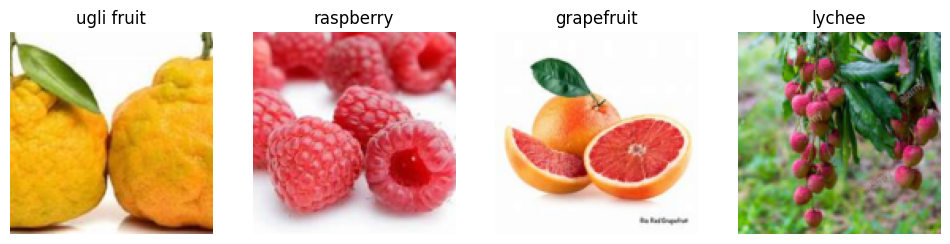

In [8]:
dls.valid.show_batch(max_n=4, nrows=1)

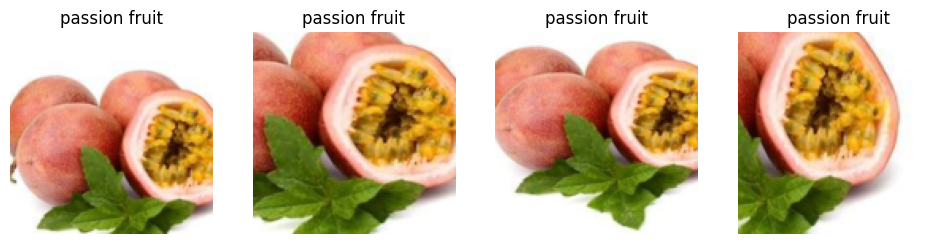

In [9]:
# Apply data augmentation to the dataset 

fruits = fruits.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = fruits.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [10]:
# Build dataloader and gradient accumulation callback

accum = 4
fruits = fruits.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = fruits.dataloaders(path, bs=64//accum)

cbs = GradientAccumulation(64)

In [11]:
timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_mlp',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge',
 'convnext_xxlarge',
 'convnextv2_atto',
 'convnextv2_base',
 'convnextv2_femto',
 'convnextv2_huge',
 'convnextv2_large',
 'convnextv2_nano',
 'convnextv2_pico',
 'convnextv2_small',
 'convnextv2_tiny']

In [12]:
# fine-tune the model
learn = vision_learner(dls, 'convnext_base_in22ft1k' , metrics=error_rate, cbs=cbs).to_fp16()
learn.fine_tune(3)

/usr/local/lib/python3.9/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_base_in22ft1k to current convnext_base.fb_in22k_ft_in1k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,0.355920,0.256833,0.068749,27:05


epoch,train_loss,valid_loss,error_rate,time
0,0.254552,0.201063,0.055628,47:15
1,0.214083,0.184929,0.049122,47:20
2,0.154516,0.167903,0.044459,47:15


In [13]:
# export model to pkl file
learn.export()